##### Original Dataset
| 컬럼명                   | 타입        | 설명               | 
| --------------------- | --------- | ---------------- |
| `user_id`              | INT       | 사용자 고유 ID        | 
| `gender`                | VARCHAR   | 성별 (Male/Female) | 
| `age`                   | INT       | 사용자 나이           | 
| `country`               | VARCHAR   | 접속 국가            | 
| `subscription_type`     | VARCHAR   | 요금제 종류           |
| `listening_time`        | FLOAT     | 하루 음악 청취 시간(분)   | 
| `songs_played_per_day`  | FLOAT     | 하루 재생 곡수         |
| `skip_rate`             | FLOAT     | 스킵률              |
| `device_type`           | VARCHAR   | 기기 종류            |
| `ads_listened_per_week` | INT       | 주간 광고 시청 수       |
| `offline_listening`     | INT (0/1) | 오프라인 재생 기능 여부    |
| `is_churned`            | INT(0/1)  | 이탈 여부            |

##### Feature Engineering (제외 xxxxxxxxxxxx) ---> 주석처리
| 컬럼명                | 타입      | 설명                                |
| --------------------- | --------- | ------------------------------------ |
| `engagement_score`   | FLOAT   | listening_time × songs_played_per_day             |
| `songs_per_minute` | FLOAT | songs_played_per_day / listening_time               |
| `skip_intensity`     | FLOAT   | skip_rate × songs_played_per_day  |
| `skip_rate_cap`         | FLOAT   | skip_rate.clip(0, 1.5) |
| `ads_pressure`         | FLOAT   | ads_listened_per_week / listening_time |

##### 시계열 정보
| 피처명 | 타입 | 설명 | 예상 기여도 |
|--------|------|------|-------------|
| `listening_time_trend_7d` | float | 최근 7일 청취 시간 변화율 (%) | 높음 |
| `login_frequency_30d` | int | 최근 30일 로그인 횟수 | 높음 |
| `days_since_last_login` | int | 마지막 로그인 후 경과 일수 | 높음 |
| `skip_rate_increase_7d` | float | 최근 1주 vs 이전 1주 스킵률 증가율 | 중간 |
| `freq_of_use_trend_14d` | float | 최근 2주 사용 빈도 변화율 (%) | 높음 |

##### 고객 접점 
| 피처명 | 타입 | 설명 | 예상 기여도 |
|--------|------|------|-------------|
| `customer_support_contact` | bool | 최근 30일 내 고객센터 문의 여부 | 중간 |
| `payment_failure_count` | int | 결제 실패 횟수 | 높음 |
| `promotional_email_click` | bool | 프로모션 이메일 클릭 여부 | 낮음 |
| `app_crash_count_30d` | int | 최근 30일 앱 크래시 횟수 | 중간 |

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid", palette="muted")

# -----------------------------------
# 지용님(with 클로드)의 결측치/이상치 처리 규칙
# -----------------------------------

def preprocess_for_eda(df):
    df = df.copy()

    # -----------------------------
    # 1) 결측치 처리 규칙
    # -----------------------------

    # 핵심 활동 지표 → median
    for col in ["listening_time", "songs_played_per_day"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # 문제 관련 지표 → 0
    for col in ["payment_failure_count", "app_crash_count_30d"]:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # 이벤트성 boolean → False
    for col in ["customer_support_contact", "promotional_email_click"]:
        if col in df.columns:
            df[col] = df[col].fillna(False)

    # -----------------------------
    # 2) 파생 변수 재계산
    # -----------------------------
    # if {"listening_time", "songs_played_per_day"}.issubset(df.columns):

    #     df["engagement_score"] = df["listening_time"] * df["songs_played_per_day"]
    #     df["songs_per_minute"] = df["songs_played_per_day"] / df["listening_time"].replace(0, np.nan)
    #     df["skip_intensity"] = df["skip_rate"] * df["songs_played_per_day"]

    # -----------------------------
    # 3) 이상치 처리 (IQR Clip)
    # -----------------------------
    numeric_cols = df.select_dtypes(include=[int, float]).columns
    numeric_cols = [c for c in numeric_cols if c not in ["user_id", "is_churned"]]

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df[col] = df[col].clip(lower, upper)

    return df


In [10]:
# ----------------------------------------
# 1) 데이터 로드
# ----------------------------------------
df_raw = pd.read_csv("../data/enhanced_data_clean.csv")

df = preprocess_for_eda(df_raw)

# inline plotting
%matplotlib inline

In [3]:
# ----------------------------------------
# 2) 기본 정보 확인
# ----------------------------------------
display(df.head())
df.info()
df.describe()


print(df.isnull().sum())

# 총 8000행!! 26개 칼럼 존재
# 모든 칼럼에 결측값이 존재하지 xxxx
#

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,...,ads_pressure,listening_time_trend_7d,login_frequency_30d,days_since_last_login,skip_rate_increase_7d,freq_of_use_trend_14d,customer_support_contact,payment_failure_count,promotional_email_click,app_crash_count_30d
0,1,Female,54,CA,Free,26.0,23.0,0.20,Desktop,12.5,...,0.0,5.636497,13,12,-4.905122,4.083913,1,1.0,1,0
1,2,Other,33,DE,Family,141.0,62.0,0.34,Web,0.0,...,0.0,-4.494792,15,10,10.284849,-3.974305,0,1.0,0,1
2,3,Male,38,AU,Premium,199.0,38.0,0.04,Mobile,0.0,...,0.0,3.299849,21,4,-2.989404,-5.228975,1,0.0,0,3
3,4,Female,22,CA,Student,36.0,2.0,0.31,Mobile,0.0,...,0.0,-10.141738,24,16,10.692953,10.913302,0,0.0,0,2
4,5,Other,29,US,Family,250.0,57.0,0.36,Mobile,0.0,...,0.0,-11.099534,13,4,-7.773562,10.065373,0,2.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   8000 non-null   int64  
 1   gender                    8000 non-null   object 
 2   age                       8000 non-null   int64  
 3   country                   8000 non-null   object 
 4   subscription_type         8000 non-null   object 
 5   listening_time            8000 non-null   float64
 6   songs_played_per_day      8000 non-null   float64
 7   skip_rate                 8000 non-null   float64
 8   device_type               8000 non-null   object 
 9   ads_listened_per_week     8000 non-null   float64
 10  offline_listening         8000 non-null   int64  
 11  is_churned                8000 non-null   int64  
 12  engagement_score          8000 non-null   float64
 13  songs_per_minute          8000 non-null   float64
 14  skip_int

In [4]:
# ----------------------------------------
# 3) 컬럼 타입 분류
# ----------------------------------------

categorical_cols = [
    "gender",
    "country",
    "subscription_type",
    "device_type",
    "offline_listening",
    "customer_support_contact",
    "promotional_email_click"
]

numeric_cols = [
    "age",
    "listening_time",
    "songs_played_per_day",
    "skip_rate",
    "ads_listened_per_week",
    # "ads_pressure",
    # "engagement_score",
    # "songs_per_minute",
    # "skip_intensity",
    # "skip_rate_cap",

    # 시계열 기반
    "listening_time_trend_7d",
    "login_frequency_30d",
    "days_since_last_login",
    "skip_rate_increase_7d",
    "freq_of_use_trend_14d",

    # 고객 접점
    "payment_failure_count",
    "app_crash_count_30d"
]

target_col = "is_churned"

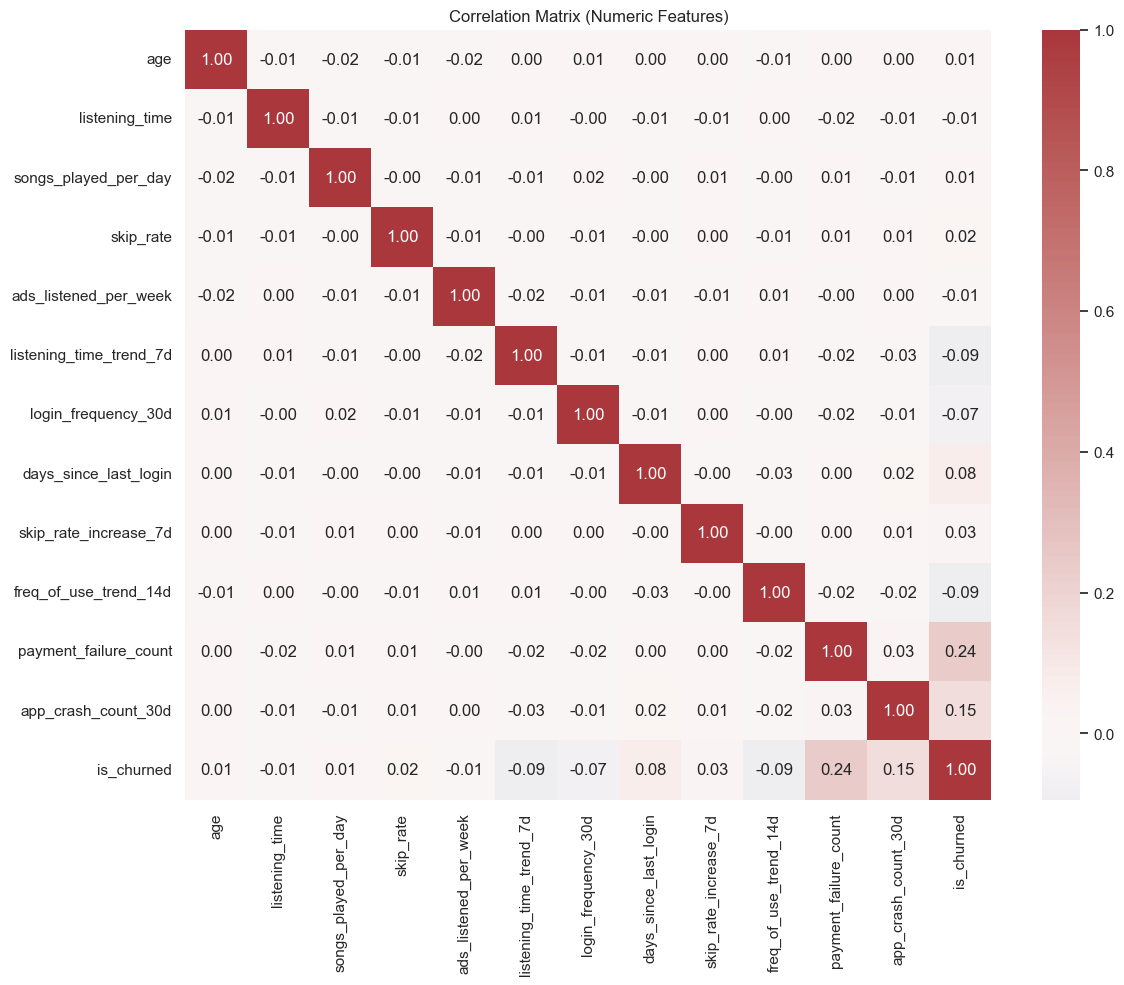

In [5]:
# ----------------------------------------
# 4) 수치형 상관분석 Heatmap
# ----------------------------------------
corr = df[numeric_cols + [target_col]].corr()

plt.figure(figsize=(13,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

# payment_failure_count(결제 실패 횟수)가 가장 높음(0.24)
# app_crash_count_30d(앱 크래시): 0.15
# freq_of_use_trend_14d(최근 사용량 변화율): 0.09
# listening_time_trend_7d(최근 청취량 변화): 0.09
# days_since_last_login(마지막 로그인 이후): 0.08
# ========= 행동 패턴이 Churn과 관련 !!!!

# 지피티왈:
## 즉,
## 이탈은 단순 스킵률/청취시간이 아니라
## 사용 패턴 변화(behavioural trends) + 앱 문제 + 결제 문제 영향이 큼.

In [6]:
# ----------------------------------------
# 5) is_churned와 가장 관련 있는 변수 TOP 10
# ----------------------------------------
print("is_churned와 상관이 높은 변수 TOP10!!!")
print(
    corr[target_col]
    .drop(target_col)
    .abs()
    .sort_values(ascending=False)
    .head(10)
)

# 상위 6개는 모두 시간 기반 행동 패턴(Time-series Features)
# 최근 앱 사용 변화가 이탈과 더 관련이 있음
# 기본적인 청취량, 스킵률 등은 유의미도가 매우 낮음


is_churned와 상관이 높은 변수 TOP10!!!
payment_failure_count      0.237909
app_crash_count_30d        0.151890
freq_of_use_trend_14d      0.094287
listening_time_trend_7d    0.090018
days_since_last_login      0.075103
login_frequency_30d        0.071599
skip_rate_increase_7d      0.032026
skip_rate                  0.019813
ads_listened_per_week      0.009849
songs_played_per_day       0.009776
Name: is_churned, dtype: float64


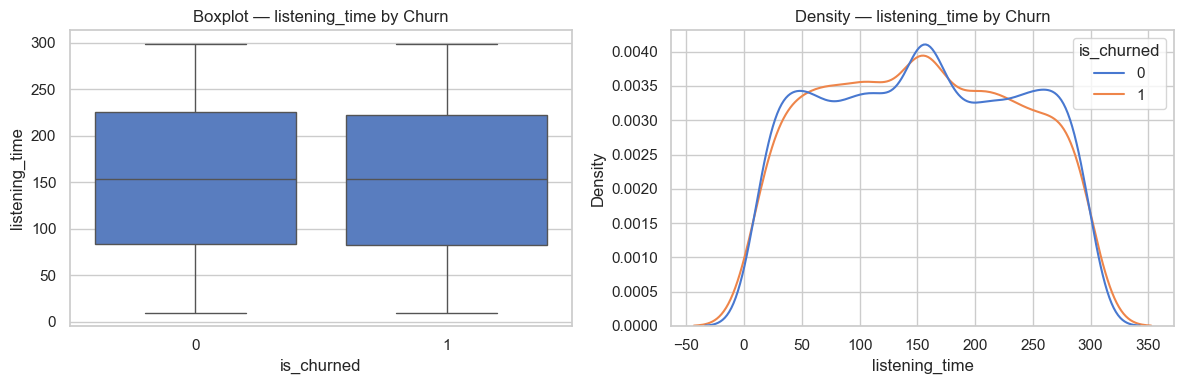

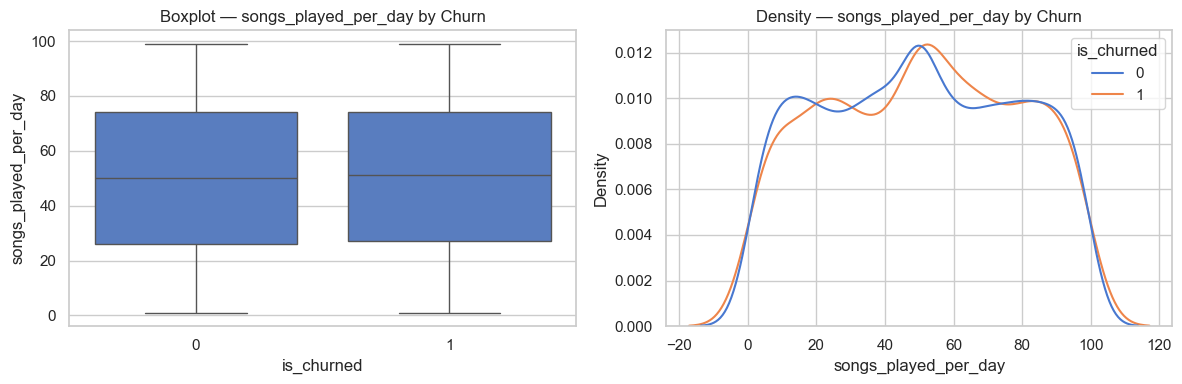

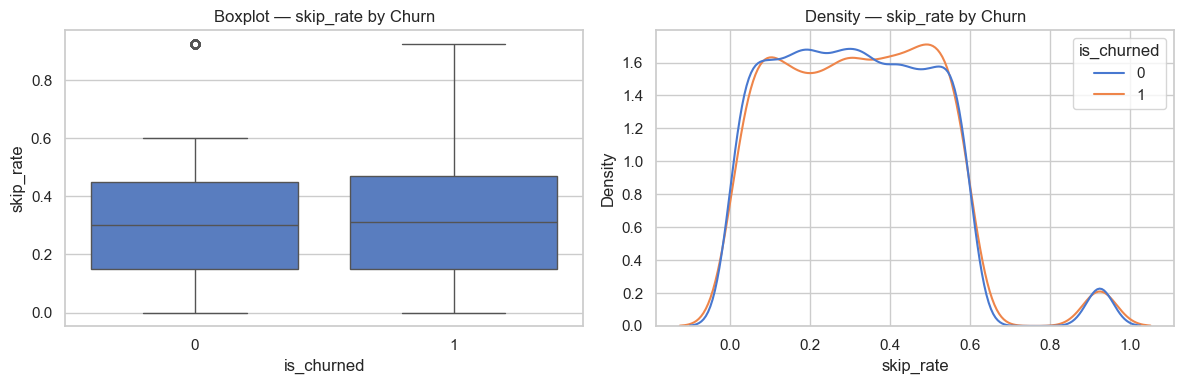

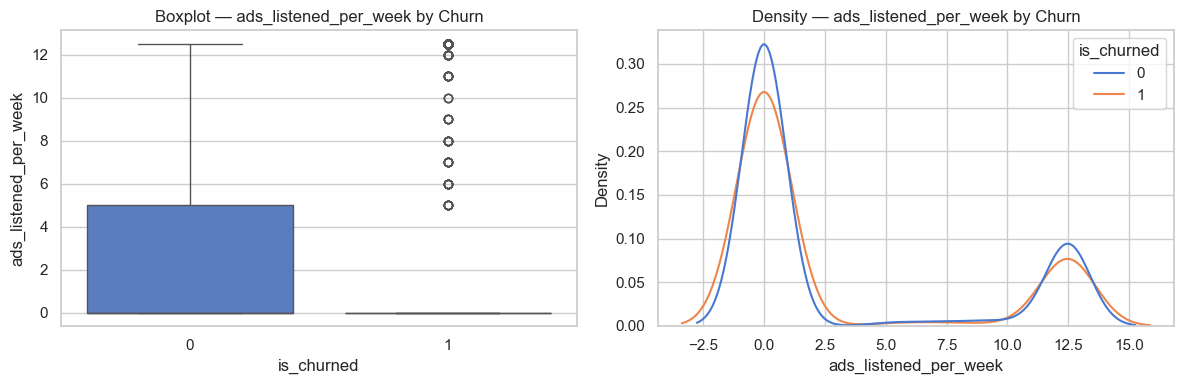

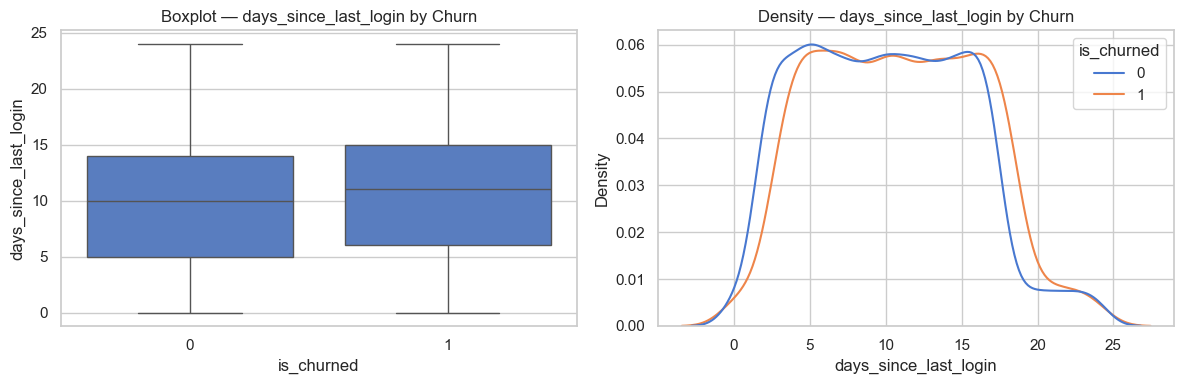

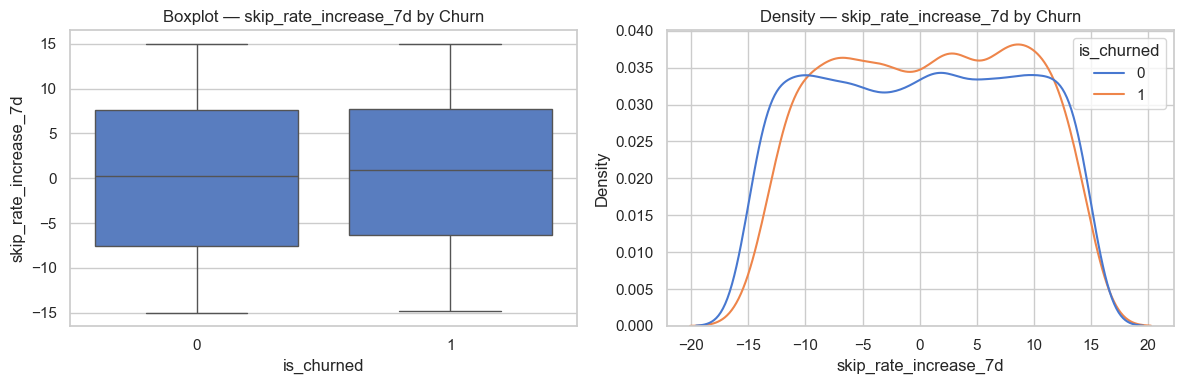

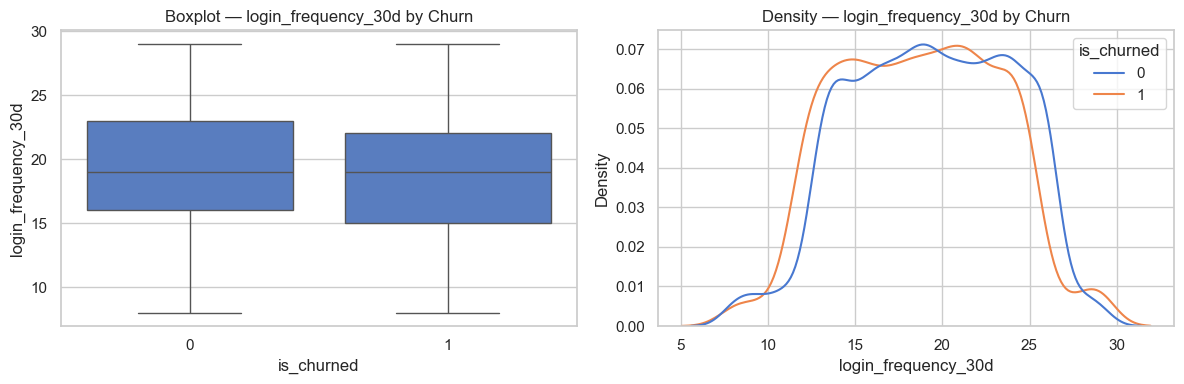

In [7]:
# ----------------------------------------
# 6) 주요 수치형 변수 분포 (Boxplot + KDE)
# ----------------------------------------

num_features_plot = [
    "listening_time",
    "songs_played_per_day",
    "skip_rate",
    "ads_listened_per_week",
    "days_since_last_login",
    "skip_rate_increase_7d",
    "login_frequency_30d",
    # "engagement_score",
]

for col in num_features_plot:
    if col in df.columns:
        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        sns.boxplot(x=target_col, y=col, data=df)
        plt.title(f"Boxplot — {col} by Churn")

        plt.subplot(1,2,2)
        sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False)
        plt.title(f"Density — {col} by Churn")

        plt.tight_layout()
        plt.show()

# listening_time == 청취시간만으로 이탈을 예측하기 어려움

# songs_played_per_day == 분포가 위와 비슷.. 강하지 않음
# skip_rate == 이탈자 약간 높지만 큰 차이로 보이지 않음
##          == skip_rate_increase_7d이 더 유용한 이유

# ads_listened_per_week == 광고 노출량이 증가할 수록 이탈 경향이 있음

# days_since_last_login == 이탈자의 중앙값이 약간 더 높음, 
##                      == 로그인을 안할 수록 이탈 위험 증가

# skip_rate_increase_7d == 이탈자의 스킵율 변화 폭이 좀 더 큼 => 갑자기 스킵이 늘어났다? 이탈 가능성 있음

# login_frequency_30d == 유저가 조금 더 자주 로그인 반면 이탈자는 전반적으로 로그인 감소 

gender — Churn 비율!!!


,count,churn_rate
gender,,
Female,2659,0.262881
Male,2691,0.251951
Other,2650,0.261887


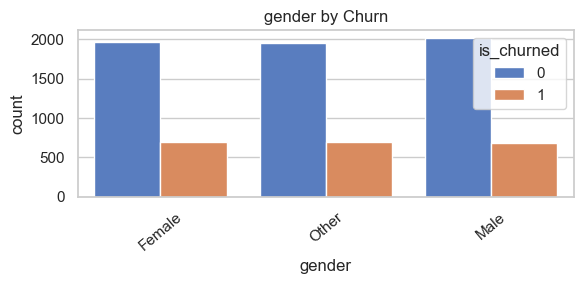

country — Churn 비율!!!


,count,churn_rate
country,,
AU,1034,0.257253
CA,954,0.248428
DE,1015,0.272906
FR,989,0.271992
IN,1011,0.243323
PK,999,0.275275
UK,966,0.247412
US,1032,0.253876


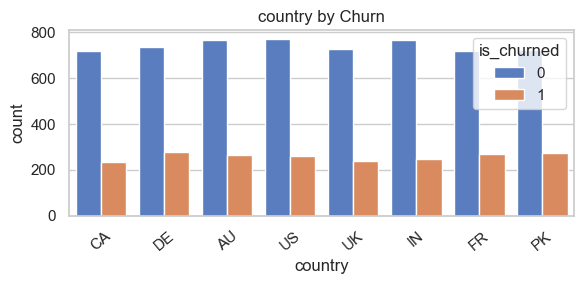

subscription_type — Churn 비율!!!


,count,churn_rate
subscription_type,,
Family,1908,0.275157
Free,2018,0.249257
Premium,2115,0.250591
Student,1959,0.261868


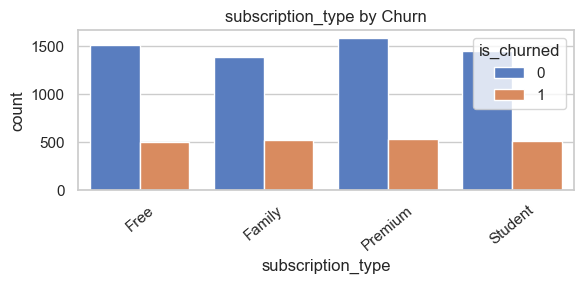

device_type — Churn 비율!!!


,count,churn_rate
device_type,,
Desktop,2778,0.257379
Mobile,2599,0.268950
Web,2623,0.250477


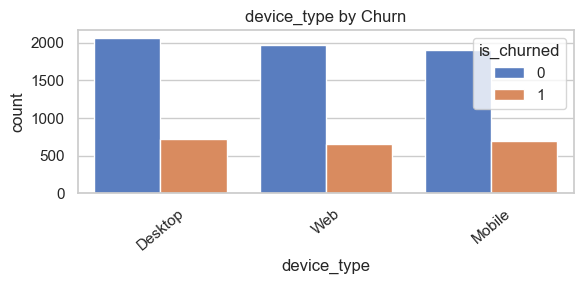

offline_listening — Churn 비율!!!


,count,churn_rate
offline_listening,,
0,2018,0.249257
1,5982,0.262120


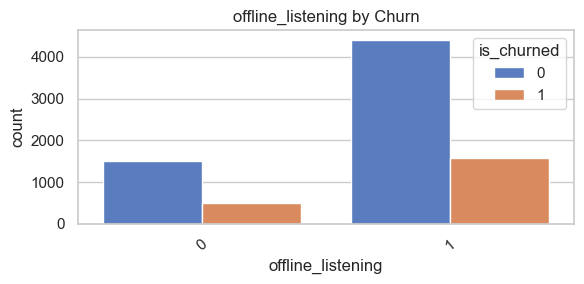

customer_support_contact — Churn 비율!!!


,count,churn_rate
customer_support_contact,,
0,5886,0.257560
1,2114,0.262535


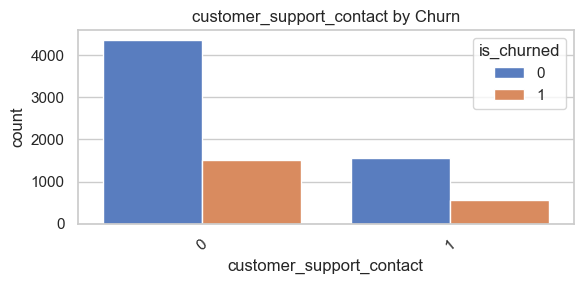

promotional_email_click — Churn 비율!!!


,count,churn_rate
promotional_email_click,,
0,4525,0.260552
1,3475,0.256691


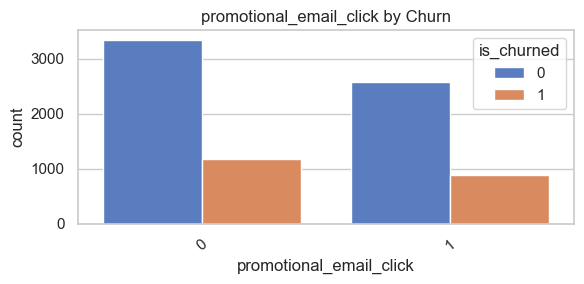

In [8]:
# ----------------------------------------
# 7) 범주형 변수 분포 및 Churn 비율
# ----------------------------------------

# 범주형 전체를 사용하도록 확장
for col in categorical_cols:
    if col in df.columns:
        print(f"{col} — Churn 비율!!!")
        display(
            df.groupby(col)[target_col]
              .agg(["count", "mean"])
              .rename(columns={"mean": "churn_rate"})
        )

        plt.figure(figsize=(6,3))
        sns.countplot(data=df, x=col, hue=target_col)
        plt.title(f"{col} by Churn")
        plt.xticks(rotation=40)
        plt.tight_layout()
        plt.show()

# Gender vs Churn
# ~0.25~0.26 수준 =Gender는  이탈과 큰 상관관계를 갖지 않음

# Country vs Churn
# 0.24 ~ 0.27 수준 국가 단독 변수만으로 이탈을 정확히 설명하기 어렵다

# Subscription Type vs Churn
# free 요금제가 약간 높음 --> 무료 → 유료 전환 전략은 먹힌다고 볼 수 있음

# Device Type vs Churn
# 0.25~0.26 수준 - 예측이 매우 낮다

# Offline Listening vs Churn
# OfflineListening(1)이 오히려 이탈자가 더 많음 but 비율로 보면 큰차이 xx

# Customer Support Contact vs Churn
# 최근 30일 동안 고객센터 문의가 있는 사용자(1) 는 churn 비율이 약간 더 높음

# Promotional Email Click vs Churn
# ~0.26 수준으로 이메일 클릭 여부가 차이 거의 없음